In [1]:
import sys
import os
import pandas as pd
import numpy as np

from keras.layers import Input, Embedding, LSTM, TimeDistributed, Dense
from keras.models import Model, load_model

# To import 'katakana' from relative path
sys.path.append(os.path.abspath(os.path.join('..')))

INPUT_LENGTH = 20
OUTPUT_LENGTH = 20


Using TensorFlow backend.


In [2]:
print(sys.path[-1])

/home/io/Desktop/katakana-from-Eng-to-Jap


# Data pre-processing

In [3]:
data = pd.read_csv('../data/joined_titles.csv', header=None)
print(data[0][:2], data[1][:2])
print('------------------------------------------------------------')
data = data.sample(frac=1, random_state=0) # random_state=0 is seed for the random number generator
print(data[0][:2], data[1][:2])
print('------------------------------------------------------------')

# `str.lower()` is to convert a string from uppercase, or even part uppercase to lowercase
utf8_eng = [s.decode('utf-8').lower() for s in data[0]]
utf8_kat = [s.decode('utf-8') for s in data[1]]
print(utf8_eng[:2], utf8_kat[:2])
print('------------------------------------------------------------')

data_size = len(data)
# We will use the first 0-60th %-tile (60% of data for the training
training_utf8_eng  = utf8_eng[data_size*0/100:data_size*60/100]
training_utf8_kat = utf8_kat[data_size*0/100:data_size*60/100]

# We will use the first 60-70th %-tile (10%) of data for the training
validation_utf8_eng = utf8_eng[data_size*60/100:data_size*70/100]
validation_utf8_kat = utf8_kat[data_size*60/100:data_size*70/100]

print('training size is {}'.format(len(training_utf8_eng)))
print('validation size is {}'.format(len(validation_utf8_eng)))

(0    Unschooling
1       Lovosice
Name: 0, dtype: object, 0    アンスクーリング
1      ロヴォシツェ
Name: 1, dtype: object)
------------------------------------------------------------
(11206      Dorogobuzh
80376    Gail Hopkins
Name: 0, dtype: object, 11206       ドロゴブージ
80376    ゲイル・ホプキンス
Name: 1, dtype: object)
------------------------------------------------------------
([u'dorogobuzh', u'gail hopkins'], [u'\u30c9\u30ed\u30b4\u30d6\u30fc\u30b8', u'\u30b2\u30a4\u30eb\u30fb\u30db\u30d7\u30ad\u30f3\u30b9'])
------------------------------------------------------------
training size is 64356
validation size is 10726


### Transform data into Numpy arrays

We transform the sequences of characters into sequences of integer IDs. This will be done by using pre-written functions in `encoding` module. 
- First, `encoding.build_characters_encoding` will build encoding/decoding dictionary from the data. 
- Then, `encoding.transform` will transform the data into numpy array.

Check [the previous notebook](./Writing Katakana using Sequence-to-Sequence in Keras) for the details about the transformation.

In [4]:
def char_int_relation(names):
    """
    input:
        names: list of strings
    return:
        char2int
        int2char
        count
    """
    count = 2
    char2int = {}
    int2char = {1: 'START'}
    for c in set([c for name in names for c in name]):
        char2int[c] = count
        int2char[count] = c
        count += 1
    return char2int, int2char, count

def transform(char2int, utf8_eng_or_kat, vector_size=20):
    """
    input:
        encoding: encoding dict built by char_int_relation()
        utf8_eng_or_kat: list of strings
        vector_size:
    return:
    """
    transformed_data = np.zeros(
        shape=(len(utf8_eng_or_kat), vector_size), 
        dtype='int')
    for i in range(len(utf8_eng_or_kat)):
        for j in range(min(len(utf8_eng_or_kat[i]), vector_size)):
            transformed_data[i][j] = char2int[utf8_eng_or_kat[i][j]]
    return transformed_data

In [5]:
engchar2int_dict, int2engchar_dict, eng_char_size = char_int_relation(utf8_eng)
katchar2int_dict, int2katchar_dict, kat_char_size = char_int_relation(utf8_kat)

print('English character dict size:', eng_char_size)
print('Katakana character dict size:', kat_char_size)

training_encoder_input = transform(
    engchar2int_dict, training_utf8_eng, vector_size=INPUT_LENGTH)
encoded_training_output = transform(
    katchar2int_dict, training_utf8_kat, vector_size=OUTPUT_LENGTH)

print('training_encoder_input', training_encoder_input.shape)
print('encoded_training_output', encoded_training_output.shape)

encoded_validation_input = transform(
    engchar2int_dict, validation_utf8_eng, vector_size=INPUT_LENGTH)  # INPUT_LENGTH=20
encoded_validation_output = transform(
    katchar2int_dict, validation_utf8_kat, vector_size=OUTPUT_LENGTH) # OUTPUT_LENGTH=20

print('encoded_validation_input', encoded_validation_input.shape)
print('encoded_validation_output', encoded_validation_output.shape)

('English character dict size:', 54)
('Katakana character dict size:', 89)
('training_encoder_input', (64356, 20))
('encoded_training_output', (64356, 20))
('encoded_validation_input', (10726, 20))
('encoded_validation_output', (10726, 20))


# Sequence-to-Sequence in Keras

### Encoder / Decoder

In [6]:
encoder_input = Input(shape=(INPUT_LENGTH,))
decoder_input = Input(shape=(OUTPUT_LENGTH,))

from keras.layers import SimpleRNN

encoder = Embedding(eng_char_size, 64, 
                    input_length=INPUT_LENGTH, 
                    mask_zero=True)(encoder_input)
encoder = LSTM(64, 
               return_sequences=True, 
               unroll=True)(encoder)
encoder_last = encoder[:,-1,:]

print('encoder', encoder)
print('encoder_last', encoder_last)

decoder = Embedding(kat_char_size, 64, 
                    input_length=OUTPUT_LENGTH, 
                    mask_zero=True)(decoder_input)
decoder = LSTM(64, 
               return_sequences=True, 
               unroll=True
              )(decoder, initial_state=[encoder_last, encoder_last])

print('decoder', decoder)

('encoder', <tf.Tensor 'lstm_1/transpose_2:0' shape=(?, 20, 64) dtype=float32>)
('encoder_last', <tf.Tensor 'strided_slice:0' shape=(?, 64) dtype=float32>)
('decoder', <tf.Tensor 'lstm_2/transpose_2:0' shape=(?, 20, 64) dtype=float32>)


### Attention Mechanism

Reference: 
[Effective Approaches to Attention-based Neural Machine Translation](https://arxiv.org/pdf/1508.04025.pdf)'s 
**Global Attention** with **Dot**-based scoring function (Section 3, 3.1)


In [7]:
from keras.layers import Activation, dot, concatenate

# Equation (7) with 'dot' score from Section 3.1 in the paper.
# Note that we reuse Softmax-activation layer instead of writing tensor calculation
# dot([(?, 20, 64), (?, 20, 64)], axes=[2, 2]) = (?, 20, 20)
attention = dot([decoder, encoder], axes=[2, 2])
print('attention before activation', attention)
attention = Activation('softmax', name='attention')(attention)
print('attention after activation', attention)

# dot([(?, 20, 20), (?, 20, 64)], axes=[2, 1]) = (?, 20, 64)
context = dot([attention, encoder], axes=[2,1])
print('context', context)

decoder_combined_context = concatenate([context, decoder])
print('decoder_combined_context', decoder_combined_context)

# Has another weight + tanh layer as described in equation (5) of the paper
output = TimeDistributed(Dense(64, activation="tanh"))(
    decoder_combined_context)
print('output', output)
output = TimeDistributed(Dense(
    kat_char_size, 
    activation="softmax"))(output)
print('output', output)

('attention before activation', <tf.Tensor 'dot_1/MatMul:0' shape=(?, 20, 20) dtype=float32>)
('attention after activation', <tf.Tensor 'attention/truediv:0' shape=(?, 20, 20) dtype=float32>)
('context', <tf.Tensor 'dot_2/MatMul:0' shape=(?, 20, 64) dtype=float32>)
('decoder_combined_context', <tf.Tensor 'concatenate_1/concat:0' shape=(?, 20, 128) dtype=float32>)
('output', <tf.Tensor 'time_distributed_1/Reshape_1:0' shape=(?, 20, 64) dtype=float32>)
('output', <tf.Tensor 'time_distributed_2/Reshape_1:0' shape=(?, 20, 89) dtype=float32>)


In [8]:
model = Model(inputs=[encoder_input, decoder_input], outputs=[output])
model.compile(optimizer='adam', loss='categorical_crossentropy')

## Training the model

In [9]:
training_decoder_input = np.zeros_like(encoded_training_output)
training_decoder_input[:, 1:] = encoded_training_output[:,:-1]
training_decoder_input[:, 0] = 1 # =encoding.CHAR_CODE_START
training_decoder_output = np.eye(kat_char_size)[
    encoded_training_output.astype('int')]

validation_encoder_input = encoded_validation_input
validation_decoder_input = np.zeros_like(encoded_validation_output)
validation_decoder_input[:, 1:] = encoded_validation_output[:,:-1]
validation_decoder_input[:, 0] = 1 # =encoding.CHAR_CODE_START
validation_decoder_output = np.eye(kat_char_size)[
    encoded_validation_output.astype('int')]

In [10]:
if os.path.isfile('model.h5'):
    model = load_model('model.h5')
else:
    model.fit(x=[training_encoder_input, training_decoder_input], 
              y=[training_decoder_output],
          validation_data=([validation_encoder_input, validation_decoder_input],
                           [validation_decoder_output]),
          verbose=2, batch_size=64, epochs=30)

model.fit(x=[training_encoder_input, training_decoder_input], 
          y=[training_decoder_output],
          validation_data=([validation_encoder_input, validation_decoder_input],
                           [validation_decoder_output]),
          verbose=2, batch_size=64, epochs=1)

model.save('model.h5')

Train on 64356 samples, validate on 10726 samples
Epoch 1/1
 - 33s - loss: 0.5785 - val_loss: 0.7054


### Testing the model


In [11]:
def generate(text):
    encoder_input = transform(engchar2int_dict, [text.lower()], 20)
    decoder_input = np.zeros(shape=(len(encoder_input), OUTPUT_LENGTH))
    decoder_input[:,0] = 1 # =encoding.CHAR_CODE_START
    for i in range(1, OUTPUT_LENGTH):
        output = model.predict([encoder_input, decoder_input]).argmax(axis=2)
        decoder_input[:,i] = output[:,i]
    return decoder_input[:,1:]

def decode(decoding, sequence):
    text = ''
    for i in sequence:
        if i == 0:
            break
        text += int2katchar_dict[i]
    return text

def to_katakana(text):
    decoder_output = generate(text)
    return decode(int2katchar_dict, decoder_output[0])


common_american_names = ['James', 'John', 'Robert', 'Mary', 'Patricia', 'Linda']
for name in common_american_names:
    print(name, to_katakana(name))

('James', u'\u30b8\u30a7\u30fc\u30e0\u30ba')
('John', u'\u30b8\u30e7\u30f3')
('Robert', u'\u30ed\u30d0\u30fc\u30c8')
('Mary', u'\u30de\u30ea\u30fc')
('Patricia', u'\u30d1\u30c8\u30ea\u30b7\u30a2')
('Linda', u'\u30ea\u30f3\u30c0')


In [12]:
print(to_katakana('Banana'))
print(to_katakana('Peter Parker'))
print(to_katakana('Jonny Snow'))

バナナ
ピーター・パーカー
ジョニー・スノウ


# Visualize Attention

The next step is visualizing the attention values of the medel during the translation. 

To do that, the first step is to locate "attention" layer of the model. The attention layer is the 7th layers of the model (`model.layers[7]`), which is the softmax activation-layer after dot-score. Or we can also simply call `model.get_layer('attention')` as we previously name the layer as "attention".

In [13]:
layers = model.layers
for l in layers:
    print('%s\tname:%s' % (str(l), l.name))
    
assert(model.layers[7] == model.get_layer('attention'))

<keras.engine.input_layer.InputLayer object at 0x7f3331ee4110>	name:input_2
<keras.engine.input_layer.InputLayer object at 0x7f3331ee4190>	name:input_1
<keras.layers.embeddings.Embedding object at 0x7f3331ee4250>	name:embedding_2
<keras.layers.embeddings.Embedding object at 0x7f3331ee41d0>	name:embedding_1
<keras.layers.recurrent.LSTM object at 0x7f3331ee4310>	name:lstm_2
<keras.layers.recurrent.LSTM object at 0x7f3331ee4750>	name:lstm_1
<keras.layers.merge.Dot object at 0x7f3331ee48d0>	name:dot_1
<keras.layers.core.Activation object at 0x7f3331ee4910>	name:attention
<keras.layers.merge.Dot object at 0x7f3331ee4950>	name:dot_2
<keras.layers.merge.Concatenate object at 0x7f3331ee4990>	name:concatenate_1
<keras.layers.wrappers.TimeDistributed object at 0x7f3331edbd10>	name:time_distributed_1
<keras.layers.wrappers.TimeDistributed object at 0x7f33358e9190>	name:time_distributed_2


We also need to re-build the model so that it returns the output from the attention layer in addition to the normal output.

In [14]:
attention_layer = model.get_layer('attention') # or model.layers[7]
attention_model = Model(inputs=model.inputs, 
                        outputs=model.outputs + [attention_layer.output])

print(attention_model)
print(attention_model.output_shape)

[(None, 20, 89), (None, 20, 20)]


In [15]:
%matplotlib inline  
import matplotlib
import matplotlib.pyplot as plt
import seaborn

seaborn.set(font=['AppleMyungjo'], font_scale=3)

def attent_and_generate(text):
    encoder_input = transform(engchar2int_dict, [text.lower()], 20)
    decoder_input = np.zeros(shape=(len(encoder_input), OUTPUT_LENGTH))
    decoder_input[:,0] = 1 # =encoding.CHAR_CODE_START
    
    for i in range(1, OUTPUT_LENGTH):
        output, attention = attention_model.predict([encoder_input, decoder_input])
        decoder_input[:,i] = output.argmax(axis=2)[:,i]
        attention_density = attention[0]
        decoded_output = decode(int2katchar_dict, decoder_input[0][1:])
        
    return attention_density, decoded_output


def visualize(text):
    attention_density, katakana = attent_and_generate(text)

    plt.clf()
    plt.figure(figsize=(28,12))
    ax = seaborn.heatmap(attention_density[:len(katakana), :len(text)+1],
        xticklabels=[w for w in text],
        yticklabels=[w for w in katakana])

    ax.invert_yaxis()
    plt.show()


/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family [u'AppleMyungjo'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


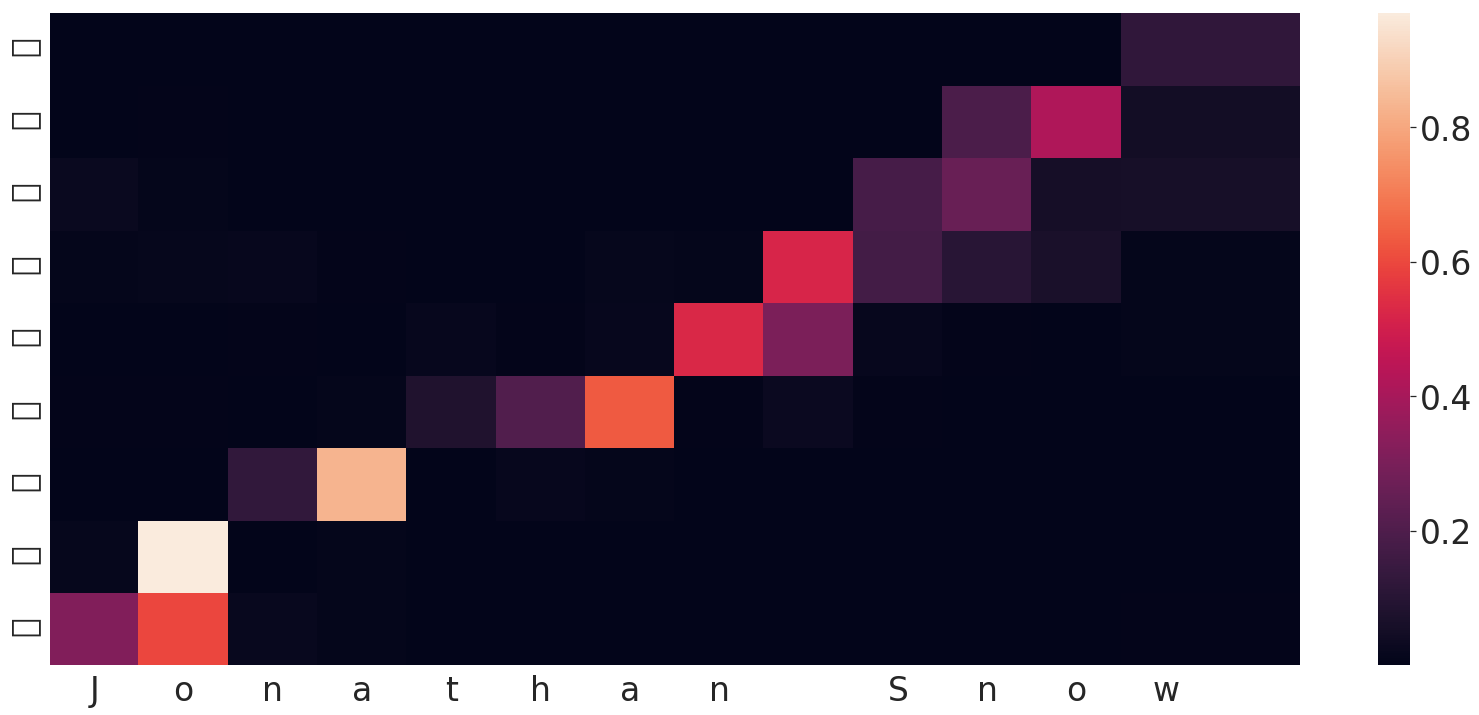

In [16]:
visualize('Jonathan Snow')

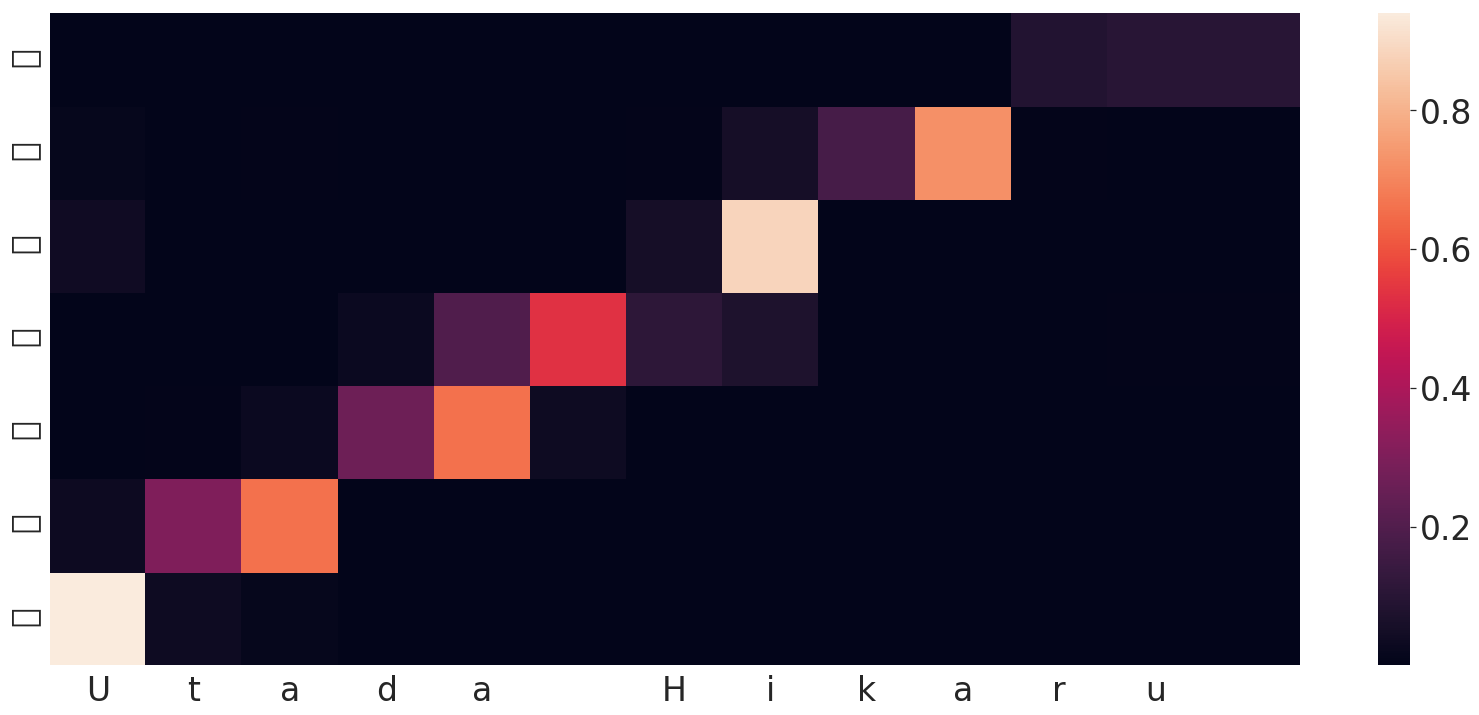

In [17]:
visualize('Utada Hikaru')

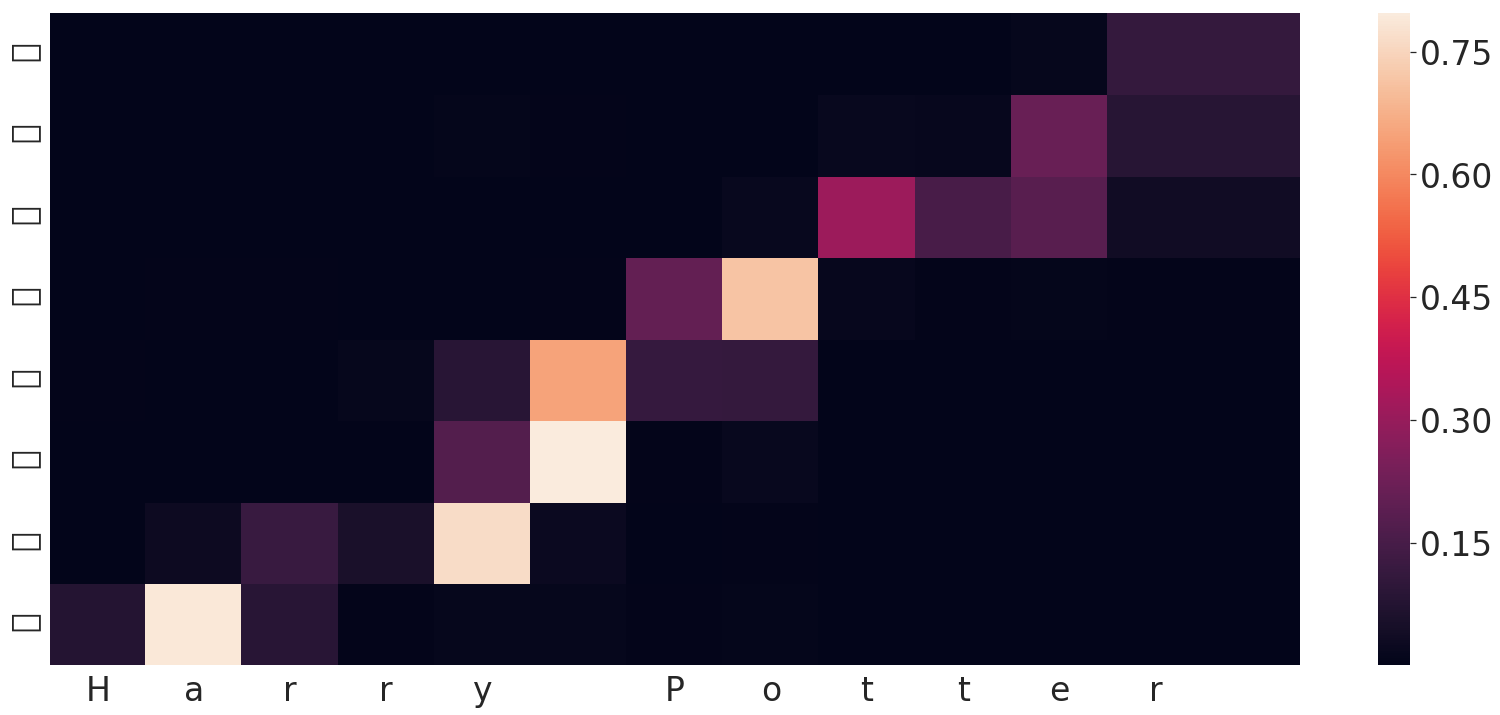

In [18]:
visualize('Harry Potter')